In [1]:
import os
os.chdir('/Users/burkelawlor/my_repos/fmri-animation')

import numpy as np
import pandas as pd

import nibabel as nib
from nilearn import image, plotting, masking
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from nilearn.maskers import NiftiMasker
import matplotlib.pyplot as plt

In [2]:
# Load the 4D fMRI data
fmri_file = 'data/sub-01_ses-V1_task-S1_run-03_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold.nii.gz'
fmri_img = nib.load(fmri_file)

In [3]:
# Total number of volumes
x, y, z, total_volumes = fmri_img.shape
print(f'Total number of volumes: {total_volumes}')

# Calculate time for each volume 
## Is first volume 0 seconds or 850 ms?
volume_seconds = [(t * 850) / 1000 for t in range(total_volumes)]
print('First 5 volume times:', volume_seconds[:5]) # first volume is 0 seconds
print('Last 5 volume times:', volume_seconds[-5:]) # last volume is 482.8 seconds (only 8 minutes 2.8 seconds??)

Total number of volumes: 569
First 5 volume times: [0.0, 0.85, 1.7, 2.55, 3.4]
Last 5 volume times: [479.4, 480.25, 481.1, 481.95, 482.8]


In [5]:
# Load in subjective ratings
subjective_ratings = pd.read_csv('data/PID1v1_s1_r3 - 2023-09-01.csv')

# Group questions by 3 and get windows to exclude
group_values = np.repeat(np.arange(1, len(subjective_ratings) // 3 + 2), 3)
subjective_ratings['q_group'] = group_values[:len(subjective_ratings)]
windows_exclude = subjective_ratings.groupby('q_group')[' Seconds since start'].agg(['min','max'])

# # Buffer the windows
# buffer = 15
# windows_exclude['min'] = windows_exclude['min'] - 15
# windows_exclude['max'] = windows_exclude['max'] + 15

# Find values of volume_seconds that are within any of the windows
mask = [False] * len(volume_seconds)
for _, row in windows_exclude.iterrows():
    mask = [m or (row['min'] <= value <= row['max']) for m, value in zip(mask, volume_seconds)]
volumes_include = ~np.array(mask)

# # Get number of volumes
# n_volumes = sum(volumes_include)
# print(n_volumes)


In [6]:
# # Apply temporal mask
# volume_seconds_clean = np.array(volume_seconds)[volumes_include]
# img_clean = image.index_img(fmri_img, volumes_include)
# img_clean.shape

In [7]:
# Make brain mask and display
masker = NiftiMasker(mask_strategy="whole-brain-template", 
                     mask_args=dict(opening=2, threshold=0.2), 
                    #  smoothing_fwhm=8, 
                     standardize='zscore_sample', 
                     high_variance_confounds=True)
masker.fit(fmri_img)

report = masker.generate_report()
report

In [8]:
# Apply the masker to the data
masked_data = masker.transform(fmri_img)
masked_img = masker.inverse_transform(masked_data)

In [ ]:
# # Get the min and max values across all volumes
# vmax = np.max(masked_img.get_fdata())
# vmin = np.min(masked_img.get_fdata())
# print(vmin, vmax)

# # Set the min and max values to be the same magnitude for colorbar to be symmetric
# abs_max = max(-vmin, vmax)
# vmin, vmax = -abs_max, abs_max

count    6.156779e+08
mean    -1.933087e-21
std      4.658692e-01
min     -1.013358e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.964963e+00
dtype: float64


<Axes: >

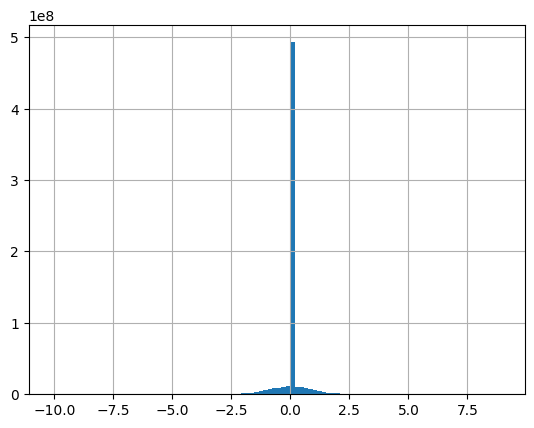

In [30]:
# Check out the fdata to set resonable vmin and vmax
fdata_1d = masked_img.get_fdata().reshape(-1)
fdata_1d = pd.Series(fdata_1d)
# print(fdata_1d.describe())
fdata_1d.hist(bins=100)

In [9]:
# Set vmin and vmax based on histogram
vmin, vmax = -2.5, 2.5

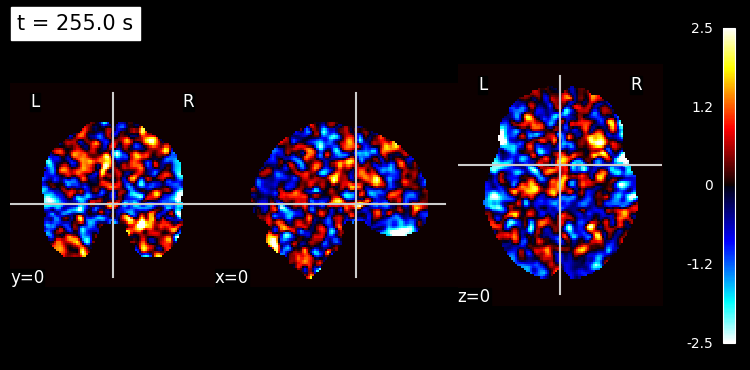

In [10]:
# Create image example 
i = 300
t = volume_seconds[i]
volume = image.index_img(masked_img, i)
display = plotting.plot_epi(volume, title=f't = {t} s', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True, vmin=vmin, vmax=vmax, cmap = nilearn_cmaps['cold_hot'])
plotting.show()

In [11]:
from PIL import Image, ImageDraw, ImageFont

def overlay_text(image, text, position, font_size=15, font_color=(255, 255, 255)):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default(size=font_size) 
    draw.text(position, text, font=font, fill=font_color, anchor='ma')

def overlay_transparent_hue(image, hue_opacity=100):
    overlay = Image.new('RGBA', image.size, (256, 256, 256, hue_opacity))
    return Image.alpha_composite(image.convert('RGBA'), overlay)

def subjective_rating_overlay(image_path):
    # Load image
    image = Image.open(image_path)

    # Overlay transparent  hue
    image = overlay_transparent_hue(image, 75)

    # Overlay text
    overlay_text(image, 'SUBJECTIVE RATING IN PROGRESS', (image.width/2, 0))

    # Save the resulting image
    image.save(image_path)

In [12]:
from alive_progress import alive_bar

with alive_bar(len(volumes_include), force_tty=True) as bar:

    for i, include in enumerate(volumes_include):
        # # Skip volumes for testing
        # if i % 10 != 0:
        #     continue

        # Make plot
        t = volume_seconds[i]
        volume = image.index_img(masked_img, i)
        display = plotting.plot_epi(volume, title=f't = {t:.2f} s', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True, vmin=vmin, vmax=vmax,  cmap=nilearn_cmaps['cold_hot'])

        # Save image
        image_path = f'images_static/volume_{i}.png'
        display.savefig(image_path)
        display.close()

        # If image is in subjective rating window, overlay hue
        if not include:
            subjective_rating_overlay(image_path)

        bar()

|                                        | ▁▃▅ 0/569 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 569/569 [100%] in 10:02.3 (0.94/s)    ▃▅▇ 132/569 [23%] in 54s (~2:58, 2.5/


In [13]:
from glob import glob
import imageio.v3 as iio

def make_gif(static_images_dir, out_path):
    # Get static image filenames and sort
    static_images = glob(f'{static_images_dir}/*.png')
    static_images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    # Load images
    frames = np.stack([iio.imread(f) for f in static_images], axis=0)
    
    # Write out gif
    iio.imwrite(out_path, frames, format='gif', fps=300)

In [15]:
make_gif('images_static', 'images_dynamic/signal_intensity_ratings_overlay.gif')